In [12]:
import numpy as np
import cPickle as pickle
from skgof import ad_test
from scipy.stats import uniform
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.ndimage.filters as filters
from scipy.interpolate import interp1d

In [2]:
pulsar_dicts_m2, _ = pickle.load(open("/.lustre/aoc/students/sstetzle/long_simulations/dicts_M2_SINI/pars_M2_SINI_pulsar_chain_dict.pkl", "rb"))
pulsar_dicts_stig, _ = pickle.load(open("/.lustre/aoc/students/sstetzle/long_simulations/dicts/pars_H3_STIG_pulsar_chain_dict.pkl", "rb"))

def get_chains(PSR, burn=0.25, thin=10):    
    try:
        with open("thinned_chains/pars_H3_H4/{}/chain_burn_{}_thin_{}.txt".format(PSR, burn, thin), "r") as infile:
            data = np.loadtxt(infile)
            key_h3_h4 = 'H3 H4'
            cosi_h3_h4 = data[:, 2]
    except:
        key_h3_h4 = 'H3 H4 (missing)'
        cosi_h3_h4 = []

    try:
        with open("thinned_chains/pars_M2_SINI/{}/chain_burn_{}_thin_{}.txt".format(PSR, burn, thin), "r") as infile:
            data = np.loadtxt(infile)
            key_m2_sini = 'M2 SINI'
            cosi_m2_sini = data[:, 2]
    except:
        if PSR in pulsar_dicts_m2.keys():
            _, _, m2_par_dict = pulsar_dicts_m2[PSR]
            key_m2_sini = 'M2 SINI (old)'
            cosi_m2_sini = m2_par_dict['COSI']
        else:
            key_m2_sini = 'M2 SINI (missing)'
            cosi_m2_sini = []
            
    try:
        with open("thinned_chains/pars_H3_STIG/{}/chain_burn_{}_thin_{}.txt".format(PSR, burn, thin), "r") as infile:
            data = np.loadtxt(infile)
            key_h3_stig = 'H3 STIG'
            cosi_h3_stig = data[:, 2]
    except:
        if PSR in pulsar_dicts_stig.keys():
            _, _, stig_par_dict = pulsar_dicts_stig[PSR]
            key_h3_stig = 'H3 STIG (old)'
            cosi_h3_stig = stig_par_dict['COSI']
        else:
            key_h3_stig = 'H3 STIG (missing)'
            cosi_h3_stig = []
    
    return {key_h3_h4:cosi_h3_h4, key_m2_sini:cosi_m2_sini, key_h3_stig:cosi_h3_stig}

In [36]:
def smooth_plot(par_chain, plot_title, nbins=100, sigma=1, pdfout=None):
    vals, binedges = np.histogram(par_chain, bins=nbins, density=True)
    bins = binedges[:-1] + (binedges[1] - binedges[0]) / 2
    vals = filters.gaussian_filter(vals, sigma=sigma)
    f = interp1d(bins, vals, kind='cubic')

    pdf = f(bins)
    pdf = np.divide(pdf, np.sum(pdf))

    cdf = [np.sum(pdf[:i]) for i in range(len(pdf))]

    fig = plt.figure("pdf", figsize=(6, 4), dpi=100)

    a = plt.plot(bins, f(bins), 'b--', lw=2, zorder=1, label="Smoothed PDF")
    fig.axes[0].get_yaxis().set_visible(False)
    plt.xlabel("p-value")
    plt.title(plot_title)
    if pdfout is not None:
        pdfout.savefig()
        plt.close()

In [38]:
def p_hist(p_vals, plot_title, nbins=50, pngout=None):
    fig = plt.figure("p_hist", figsize=(6, 4), dpi=100)
    a = plt.hist(p_vals, bins=nbins)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.xlabel("p-value")
    plt.title(plot_title)
    if pngout is not None:
        plt.savefig(pngout)
        plt.close()

In [3]:
all_pulsars = np.genfromtxt("all_pulsars.txt", dtype=str)
good_pulsars = np.genfromtxt("good_pulsars.txt", dtype=str)

In [4]:
all_chains = [get_chains(p) for p in all_pulsars]
good_chains = [get_chains(p) for p in good_pulsars]

In [5]:
# all_chains_h3_h4 = [c[c.keys()[0]] for c in all_chains]
all_chains_m2 = [c[c.keys()[1]] for c in all_chains]
all_chains_stig = [c[c.keys()[2]] for c in all_chains]

In [6]:
# good_chains_h3_h4 = [c[c.keys()[0]] for c in good_pulsars]
good_chains_m2 = [c[c.keys()[1]] for c in good_chains]
good_chains_stig = [c[c.keys()[2]] for c in good_chains]

In [31]:
all_chains_m2 = [c for c in all_chains_m2 if len(c) > 0]
all_chains_stig = [c for c in all_chains_stig if len(c) > 0]

good_chains_m2 = [c for c in good_chains_m2 if len(c) > 0]
good_chains_stig = [c for c in good_chains_stig if len(c) > 0]

N = 50000

p_vals_all_m2 = np.zeros(N)
p_vals_all_stig = np.zeros(N)

p_vals_good_m2 = np.zeros(N)
p_vals_good_stig = np.zeros(N)

compare_dist = uniform(0, 1)
for i in range(N):
    samples_all_m2 = [np.random.choice(c) for c in all_chains_m2]
    samples_all_stig = [np.random.choice(c) for c in all_chains_stig]
   
    samples_good_m2 = [np.random.choice(c) for c in good_chains_m2]
    samples_good_stig = [np.random.choice(c) for c in good_chains_stig]
    
    _, p_val_all_m2 = ad_test(samples_all_m2, compare_dist)
    _, p_val_all_stig = ad_test(samples_all_stig, compare_dist)
    
    _, p_val_good_m2 = ad_test(samples_good_m2, compare_dist)
    _, p_val_good_stig = ad_test(samples_good_stig, compare_dist)
    
    p_vals_all_m2[i] = p_val_all_m2
    p_vals_all_stig[i] = p_val_all_stig
    
    p_vals_good_m2[i] = p_val_good_m2
    p_vals_good_stig[i] = p_val_good_stig

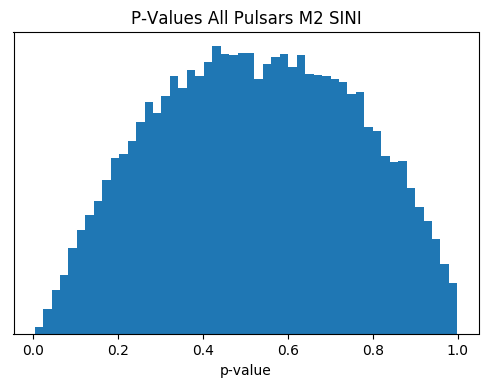

In [32]:
p_hist(p_vals_all_m2, "P-Values All Pulsars M2 SINI")

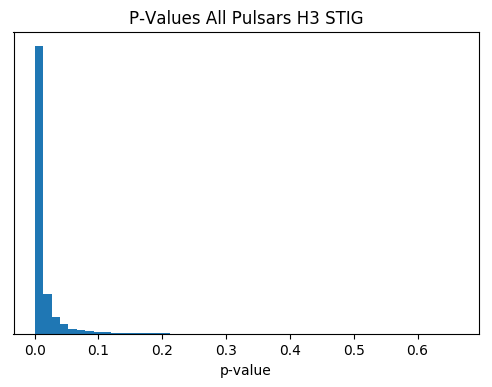

In [33]:
p_hist(p_vals_all_stig, "P-Values All Pulsars H3 STIG")

In [40]:
p_hist(p_vals_good_m2, "P-values from Anderson-Darling Test", pngout="good_p_val.png")

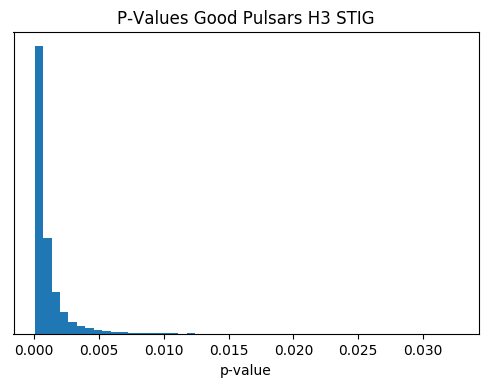

In [35]:
p_hist(p_vals_good_stig, "P-Values Good Pulsars H3 STIG")